### 📝 Задание 1: Алгоритмы цветового баланса

#### 🎯 Цель:
В этом задании вам предстоит реализовать и протестировать два классических алгоритма для автоматической коррекции цвета изображений:
* **Алгоритм «Серого мира» (Gray World)**
* **Алгоритм «Масштабирование по максимуму» (Scale-by-Max)**

Вы можете использовать свои собственные изображения. Экспериментируйте с разными снимками и анализируйте, как каждый алгоритм влияет на конечное (сбалансированное) изображение.

---

### 🎨 Цветовой баланс

В этом ноутбуке мы рассмотрим различные подходы к цветовому балансу, основанные на **гипотезе фон Криса**. Эта гипотеза предполагает, что в каждом из каналов RGB человеческий глаз воспринимает яркость независимо друг от друга. Наша задача — скорректировать каждый цветовой канал так, чтобы скомпенсировать искажения, вызванные условиями освещения.

## 💻 Шаг 2: Импорт библиотек и настройка

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

project_dir = ''


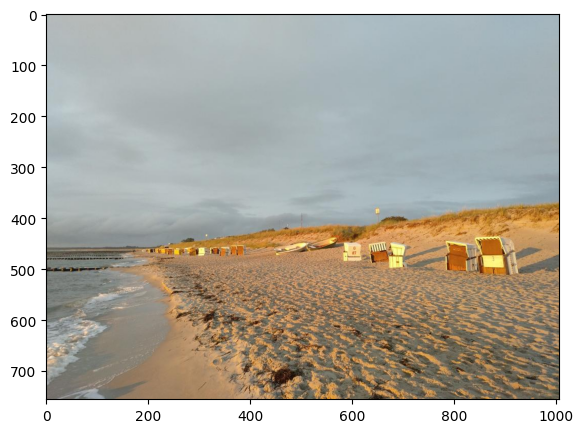

In [ ]:
img = cv2.imread(f'{project_dir}/data/sea.jpg')
img =  
plt.imshow(img)

### 🎨 Шаг 3: Алгоритм «Белой заплатки» (White Patch)
Алгоритм «Белой заплатки» — это простой и эффективный метод цветокоррекции, основанный на предположении, что самый яркий пиксель в изображении должен быть белым (т.е., иметь максимальное значение во всех цветовых каналах, например, 255, 255, 255). Мы находим такой пиксель и масштабируем все остальные пиксели в изображении, используя его значения.

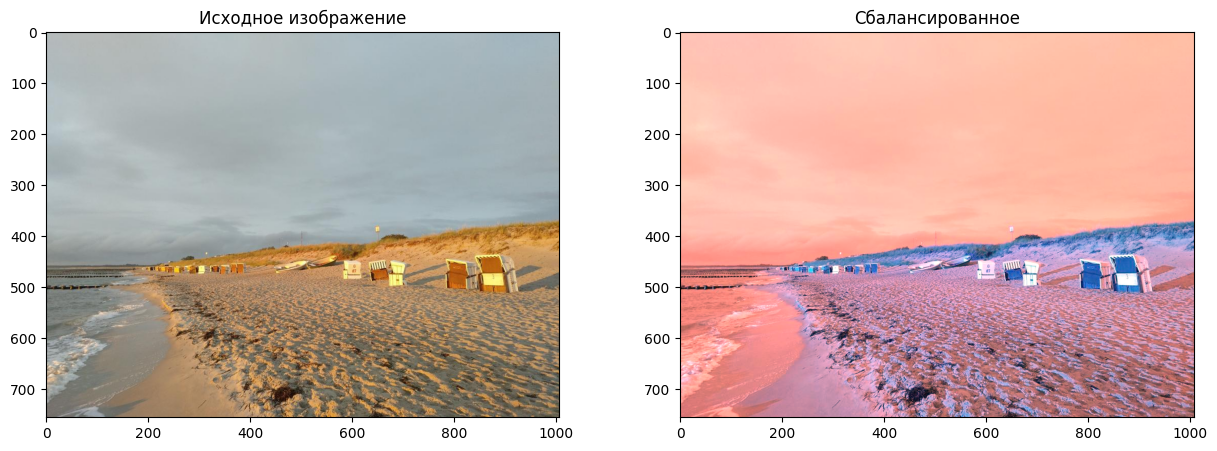

In [ ]:
# Определение координат пикселя, который мы считаем "белым".
# Эти значения нужно подобрать вручную для вашего изображения.
# Например: row, col = 485, 864
row, col = 485, 864

# Получение значений RGB для выбранного пикселя.
white = img[row, col, :]

# Вычисление коэффициентов масштабирования.
# Мы делим максимальное значение яркости (255.0) на значение каждого канала "белого" пикселя.
coeffs = 255.0 / white

# Создание нового массива для сбалансированного изображения.
# np.zeros_like() создает массив, заполненный нулями, с такими же размерами
# и типом данных, как у исходного изображения (img), но мы меняем тип на float32
# для корректного выполнения математических операций.
balanced = np.zeros_like(img, dtype=np.float32)

# Применение цветового баланса к каждому каналу.
# Мы проходим по всем трем каналам (0, 1, 2) и умножаем каждый
# канал на соответствующий коэффициент.
for channel in range(3):
    balanced[..., channel] = img[..., channel] * coeffs[channel]

# Примечание: Алгоритм "белой заплатки" не гарантирует, что значения пикселей
# останутся в допустимом диапазоне (0-255). Некоторые пиксели могут стать ярче 255.
# Чтобы избежать этого, мы нормализуем значения и "обрезаем" их.
# Преобразование значений в диапазон [0, 1].
balanced = 

# Обрезка значений, превышающих 1.
# Все значения больше 1.0 приравниваются к 1.0.
balanced[balanced > 1] = 

# Отображение исходного и сбалансированного изображений.
# plt.subplot() позволяет разместить несколько графиков в одной фигуре.
# plt.imshow() отображает изображение.
plt.subplot(121), plt.imshow(img)
plt.title('Исходное изображение')
plt.subplot(122), plt.imshow(cv2.cvtColor(np.uint8(balanced * 255), cv2.COLOR_BGR2RGB))
plt.title('Сбалансированное')
plt.show()

### 🌍 Шаг 4: Алгоритм «Серого мира» (Gray World)
Алгоритм «Серого мира» основан на предположении, что среднее значение яркости во всем изображении должно быть серым. Это означает, что средние значения для каналов красного, зеленого и синего должны быть одинаковыми. Мы вычисляем эти средние значения и корректируем каждый канал, чтобы они стали равны.

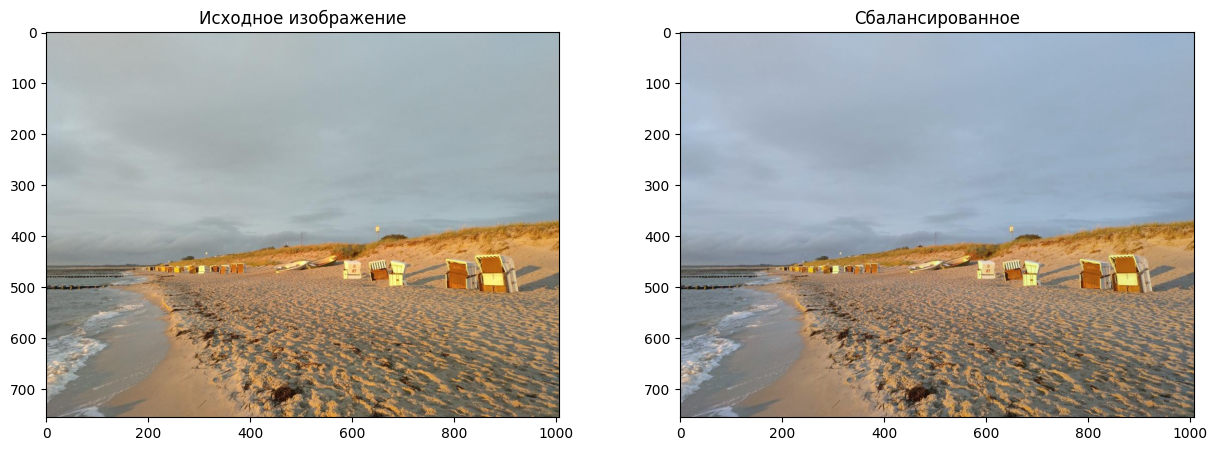

In [ ]:
# Вычисление среднего значения яркости для каждого канала.
# np.mean() вычисляет среднее значение всех пикселей в указанном канале.
mean_r = 
mean_g = 
mean_b = 

# Вычисление коэффициентов.
# Мы принимаем, что среднее значение "серого" должно быть средним
# из средних значений всех каналов.
mean_gray = (mean_r + mean_g + mean_b) / 3

# Коэффициенты вычисляются как отношение среднего "серого" к среднему
# значению каждого канала.
kr = 
kg = 
kb = 

# Применение цветового баланса.
# Мы создаем новый массив для сбалансированного изображения.
# Умножаем каждый канал на соответствующий коэффициент.
balanced = np.zeros_like(img, dtype=np.float32)
balanced[..., 0] = img[..., 0] * kr
balanced[..., 1] = img[..., 1] * kg
balanced[..., 2] = img[..., 2] * kb

# Обрезка значений, превышающих 255, и преобразование обратно в тип uint8.
balanced[balanced > 255] = 255
balanced = np.uint8(balanced)

# Отображение исходного и сбалансированного изображений.
plt.subplot(121), plt.imshow(img)
plt.title('Исходное изображение')
plt.subplot(122), plt.imshow(balanced)
plt.title('Сбалансированное')
plt.show()

### 🌅 Шаг 5: Алгоритм «Масштабирование по максимуму» (Scale-by-max)
Алгоритм «Масштабирование по максимуму» — это ещё один простой метод, основанный на предположении, что самый яркий пиксель в изображении должен быть белым. В отличие от «Белой заплатки», этот алгоритм находит самый яркий пиксель для каждого канала по отдельности и затем масштабирует весь канал так, чтобы его максимальное значение стало равным 255. Это делает его очень чувствительным к шуму или засветке, так как один-единственный яркий пиксель может сильно исказить результат.

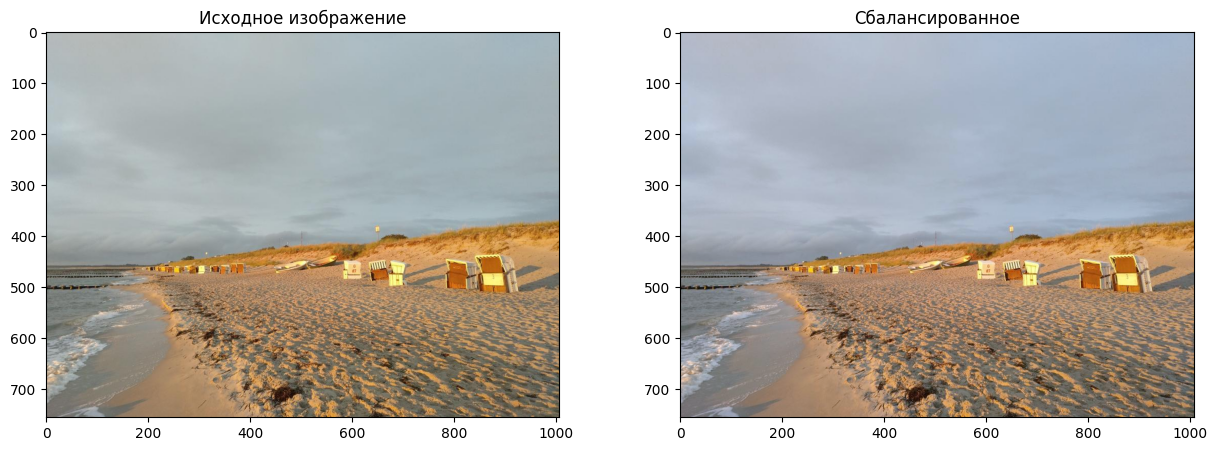

In [ ]:
# Вычисление максимального значения для каждого канала.
# np.max() возвращает максимальное значение в массиве.
max_r = 
max_g = 
max_b = 

# Создание нового массива для сбалансированного изображения.
# Используем тип float32 для вычислений, чтобы избежать потери точности.
balanced = 

# Применение цветового баланса.
# Каждый канал умножается на отношение 255 к своему максимальному значению.
balanced[..., 0] = img[..., 0] * (255.0 / max_r)
balanced[..., 1] = img[..., 1] * (255.0 / max_g)
balanced[..., 2] = img[..., 2] * (255.0 / max_b)

# Обрезка значений, превышающих 255, и преобразование обратно в тип uint8.
balanced[balanced > 255] = 255
balanced = np.uint8(balanced)

# Отображение исходного и сбалансированного изображений.
plt.subplot(121), plt.imshow(img)
plt.title('Исходное изображение')
plt.subplot(122), plt.imshow(balanced)
plt.title('Сбалансированное')
plt.show()